# Feature Engineering Baseline

Add engineered features including:
- Interaction terms between modalities
- Polynomial features
- Statistical aggregations

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')
%matplotlib inline

## Load Data

In [2]:
# Load pre-extracted featureswith open('../data/results/features_POST/extracted_features_POST.pkl', 'rb') as f:    feature_data = pickle.load(f)merged_df = feature_data['merged_df']physio_cols = feature_data['physio_cols']behavior_cols = feature_data['behavior_cols']gaze_cols = feature_data['gaze_cols']print(f"✓ Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")print(f"\nOriginal feature counts:")print(f"  Physiology: {len(physio_cols)}")print(f"  Behavior: {len(behavior_cols)}")print(f"  Gaze: {len(gaze_cols)}")print(f"  Total: {len(physio_cols) + len(behavior_cols) + len(gaze_cols)}")


✓ Loaded 12511 trials from 97 subjects

Original feature counts:
  Physiology: 13
  Behavior: 7
  Gaze: 20
  Total: 40


## Prepare Base Features

In [3]:
# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_physio = imputer.fit_transform(merged_df[physio_cols])
X_behavior = imputer.fit_transform(merged_df[behavior_cols])
X_gaze = imputer.fit_transform(merged_df[gaze_cols])

y = merged_df['outcome'].values
subjects = merged_df['subject_id'].values

print(f"Base features:")
print(f"  X_physio: {X_physio.shape}")
print(f"  X_behavior: {X_behavior.shape}")
print(f"  X_gaze: {X_gaze.shape}")

Base features:
  X_physio: (12511, 13)
  X_behavior: (12511, 7)
  X_gaze: (12511, 20)


## Feature Engineering

Create interaction features between modalities

In [4]:
def create_interaction_features(X_physio, X_behavior, X_gaze):
    """
    Create interaction features between modalities.
    """
    interactions = []
    
    # 1. Cross-modality products (sample a few key interactions)
    # Physio x Behavior interactions
    for i in range(min(5, X_physio.shape[1])):
        for j in range(min(3, X_behavior.shape[1])):
            interactions.append(X_physio[:, i] * X_behavior[:, j])
    
    # Physio x Gaze interactions
    for i in range(min(5, X_physio.shape[1])):
        for j in range(min(5, X_gaze.shape[1])):
            interactions.append(X_physio[:, i] * X_gaze[:, j])
    
    # Behavior x Gaze interactions
    for i in range(min(3, X_behavior.shape[1])):
        for j in range(min(5, X_gaze.shape[1])):
            interactions.append(X_behavior[:, i] * X_gaze[:, j])
    
    # 2. Ratios between modalities
    # Mean of each modality
    physio_mean = np.mean(X_physio, axis=1, keepdims=True)
    behavior_mean = np.mean(X_behavior, axis=1, keepdims=True)
    gaze_mean = np.mean(X_gaze, axis=1, keepdims=True)
    
    # Avoid division by zero
    eps = 1e-8
    interactions.append((physio_mean / (behavior_mean + eps)).ravel())
    interactions.append((physio_mean / (gaze_mean + eps)).ravel())
    interactions.append((behavior_mean / (gaze_mean + eps)).ravel())
    
    # 3. Statistical aggregations across modalities
    all_features = np.concatenate([X_physio, X_behavior, X_gaze], axis=1)
    interactions.append(np.std(all_features, axis=1))
    interactions.append(np.max(all_features, axis=1) - np.min(all_features, axis=1))
    
    return np.column_stack(interactions)

X_interactions = create_interaction_features(X_physio, X_behavior, X_gaze)
print(f"\nCreated {X_interactions.shape[1]} interaction features")


Created 60 interaction features


## Combine All Features

In [5]:
# Combine base features + interactions
X_combined = np.concatenate([X_physio, X_behavior, X_gaze, X_interactions], axis=1)

print(f"Final feature set: {X_combined.shape}")
print(f"  Base features: {X_physio.shape[1] + X_behavior.shape[1] + X_gaze.shape[1]}")
print(f"  Interaction features: {X_interactions.shape[1]}")
print(f"  Total: {X_combined.shape[1]}")

Final feature set: (12511, 100)
  Base features: 40
  Interaction features: 60
  Total: 100


## Train Model with Engineered Features

In [6]:
def run_loso_cv(X, y, subjects, model_name="Model"):
    """
    Run LOSO cross-validation.
    """
    print("="*70)
    print(f"{model_name}")
    print("="*70)
    
    logo = LeaveOneGroupOut()
    
    all_y_true = []
    all_y_pred = []
    subject_accuracies = []
    
    for train_idx, test_idx in logo.split(X, y, subjects):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train model
        model = RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        
        # Store results
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        subject_accuracies.append(accuracy_score(y_test, y_pred))
    
    # Calculate metrics
    overall_acc = accuracy_score(all_y_true, all_y_pred)
    overall_f1 = f1_score(all_y_true, all_y_pred, average='weighted')
    
    print(f"\nOverall Accuracy: {overall_acc:.4f}")
    print(f"Overall F1 Score: {overall_f1:.4f}")
    print(f"Mean Subject Accuracy: {np.mean(subject_accuracies):.4f} ± {stats.sem(subject_accuracies):.4f} (SEM)")
    print(f"\nClassification Report:")
    print(classification_report(all_y_true, all_y_pred))
    
    return {
        'model_name': model_name,
        'accuracy': overall_acc,
        'f1_score': overall_f1,
        'subject_accuracies': subject_accuracies,
        'y_true': all_y_true,
        'y_pred': all_y_pred
    }

# Train with engineered features
results_engineered = run_loso_cv(X_combined, y, subjects, "Random Forest with Engineered Features")

Random Forest with Engineered Features

Overall Accuracy: 0.6701
Overall F1 Score: 0.6262
Mean Subject Accuracy: 0.6718 ± 0.0150 (SEM)

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.23      0.33      4273
           1       0.69      0.90      0.78      8238

    accuracy                           0.67     12511
   macro avg       0.62      0.57      0.55     12511
weighted avg       0.64      0.67      0.63     12511



## Baseline (No Engineering) for Comparison

In [7]:
# Baseline: just concatenated features
X_baseline = np.concatenate([X_physio, X_behavior, X_gaze], axis=1)

results_baseline = run_loso_cv(X_baseline, y, subjects, "Random Forest Baseline (No Engineering)")

Random Forest Baseline (No Engineering)

Overall Accuracy: 0.6828
Overall F1 Score: 0.6484
Mean Subject Accuracy: 0.6819 ± 0.0143 (SEM)

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.29      0.38      4273
           1       0.71      0.89      0.79      8238

    accuracy                           0.68     12511
   macro avg       0.64      0.59      0.58     12511
weighted avg       0.66      0.68      0.65     12511



## Comparison

In [8]:
# Create comparison
comparison_df = pd.DataFrame({
    'Model': ['Baseline (No Engineering)', 'With Engineered Features'],
    'N_Features': [X_baseline.shape[1], X_combined.shape[1]],
    'Accuracy': [results_baseline['accuracy'], results_engineered['accuracy']],
    'F1_Score': [results_baseline['f1_score'], results_engineered['f1_score']],
    'Mean_Subject_Acc': [
        np.mean(results_baseline['subject_accuracies']),
        np.mean(results_engineered['subject_accuracies'])
    ],
    'SEM_Subject_Acc': [
        stats.sem(results_baseline['subject_accuracies']),
        stats.sem(results_engineered['subject_accuracies'])
    ]
})

print("\n" + "="*70)
print("FEATURE ENGINEERING IMPACT")
print("="*70)
print(comparison_df.to_string(index=False))

# Calculate improvement
improvement = results_engineered['accuracy'] - results_baseline['accuracy']
print(f"\n✓ Improvement: {improvement:+.4f} ({improvement*100:+.2f}%)")


FEATURE ENGINEERING IMPACT
                    Model  N_Features  Accuracy  F1_Score  Mean_Subject_Acc  SEM_Subject_Acc
Baseline (No Engineering)          40  0.682839  0.648398          0.681901         0.014292
 With Engineered Features         100  0.670130  0.626248          0.671756         0.014997

✓ Improvement: -0.0127 (-1.27%)


## Visualizations

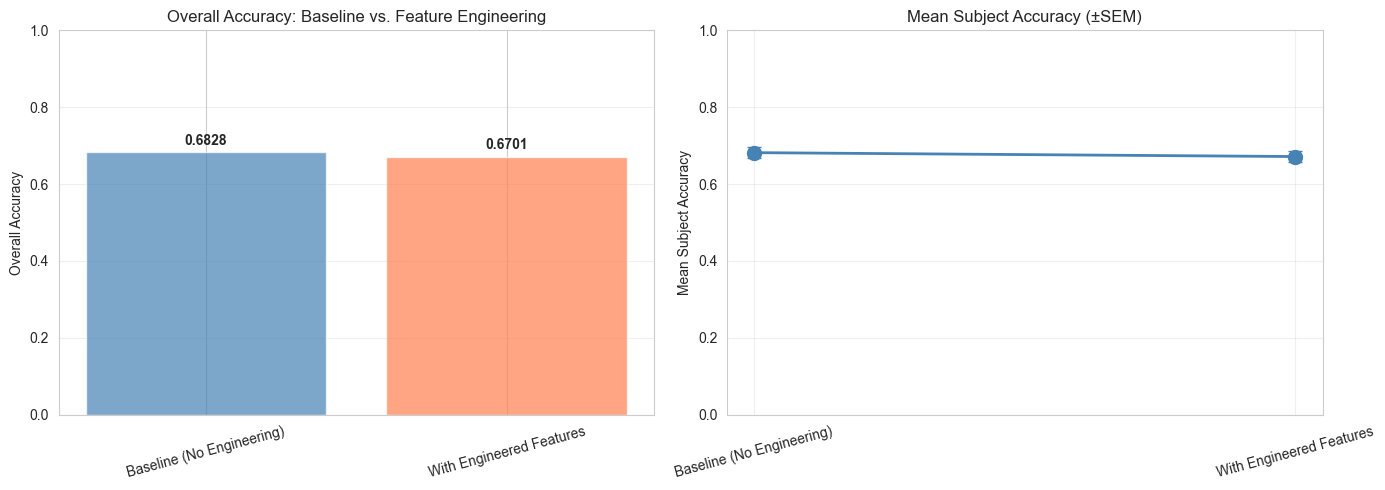

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall accuracy comparison
colors = ['steelblue', 'coral']
axes[0].bar(comparison_df['Model'], comparison_df['Accuracy'], color=colors, alpha=0.7)
axes[0].set_ylabel('Overall Accuracy')
axes[0].set_title('Overall Accuracy: Baseline vs. Feature Engineering')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=15)

# Add values on bars
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Mean subject accuracy with error bars
axes[1].errorbar(comparison_df['Model'], comparison_df['Mean_Subject_Acc'],
                yerr=comparison_df['SEM_Subject_Acc'],
                marker='o', capsize=5, linewidth=2, markersize=10, color='steelblue')
axes[1].set_ylabel('Mean Subject Accuracy')
axes[1].set_title('Mean Subject Accuracy (±SEM)')
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## Feature Count Breakdown

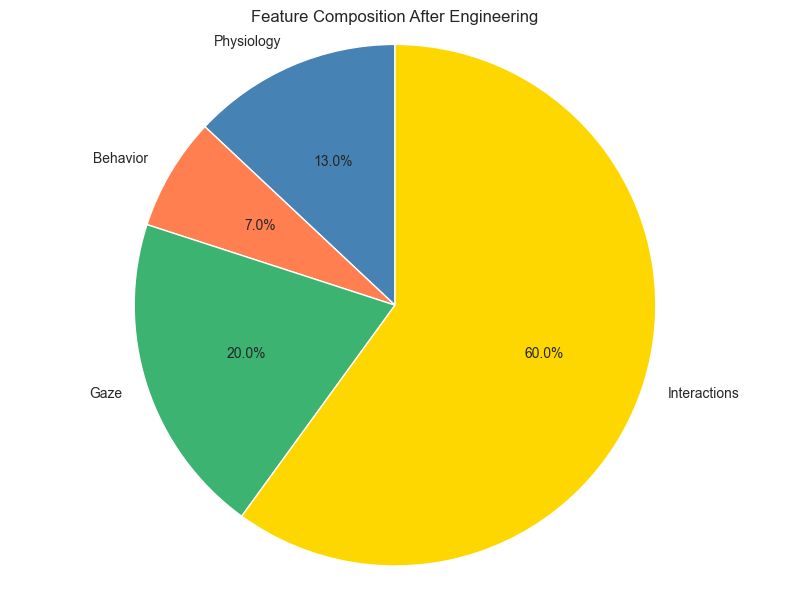


Feature breakdown:
Feature Type  Count
  Physiology     13
    Behavior      7
        Gaze     20
Interactions     60


In [10]:
# Visualize feature counts
feature_breakdown = pd.DataFrame({
    'Feature Type': ['Physiology', 'Behavior', 'Gaze', 'Interactions'],
    'Count': [
        X_physio.shape[1],
        X_behavior.shape[1],
        X_gaze.shape[1],
        X_interactions.shape[1]
    ]
})

plt.figure(figsize=(8, 6))
colors_pie = ['steelblue', 'coral', 'mediumseagreen', 'gold']
plt.pie(feature_breakdown['Count'], labels=feature_breakdown['Feature Type'],
        autopct='%1.1f%%', colors=colors_pie, startangle=90)
plt.title('Feature Composition After Engineering')
plt.axis('equal')
plt.tight_layout()
plt.show()

print("\nFeature breakdown:")
print(feature_breakdown.to_string(index=False))

## Save Results

In [11]:
# Save comparison
comparison_df.to_csv('../data/results/feature_engineering_comparison.csv', index=False)
print("✓ Saved comparison to: ../data/results/feature_engineering_comparison.csv")

# Save detailed results
results_dict = {
    'baseline': results_baseline,
    'engineered': results_engineered,
    'feature_breakdown': feature_breakdown
}

with open('../data/results/feature_engineering_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)
print("✓ Saved detailed results to: ../data/results/feature_engineering_results.pkl")

✓ Saved comparison to: ../data/results/feature_engineering_comparison.csv
✓ Saved detailed results to: ../data/results/feature_engineering_results.pkl
